In [1]:
# pip install -q google-generativeai chromadb sentence-transformers matplotlib seaborn

"""Module for understanding and visualizing embeddings for RAG"""

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import textwrap
import time
import uuid
from sklearn.decomposition import PCA

load_dotenv()

import google.generativeai as genai
import chromadb

api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=api_key)


d:\RagSession\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding Shape :  (8, 768)


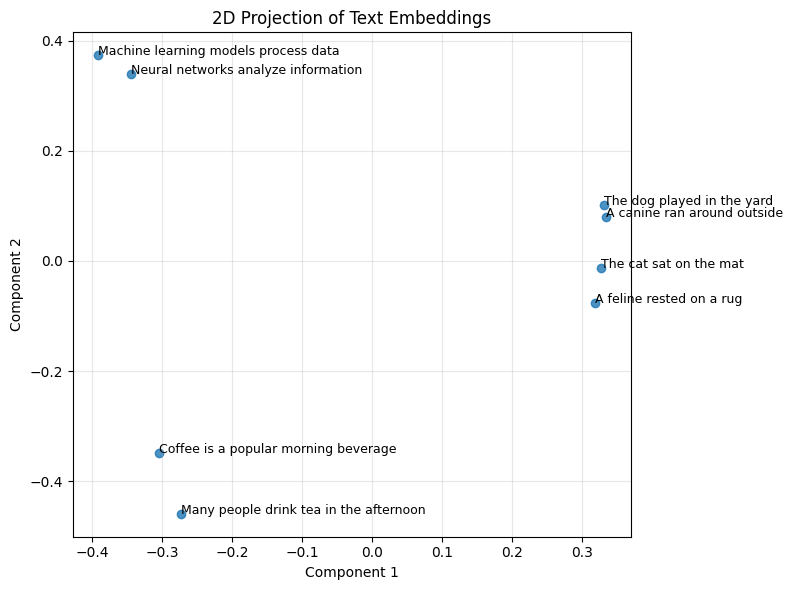

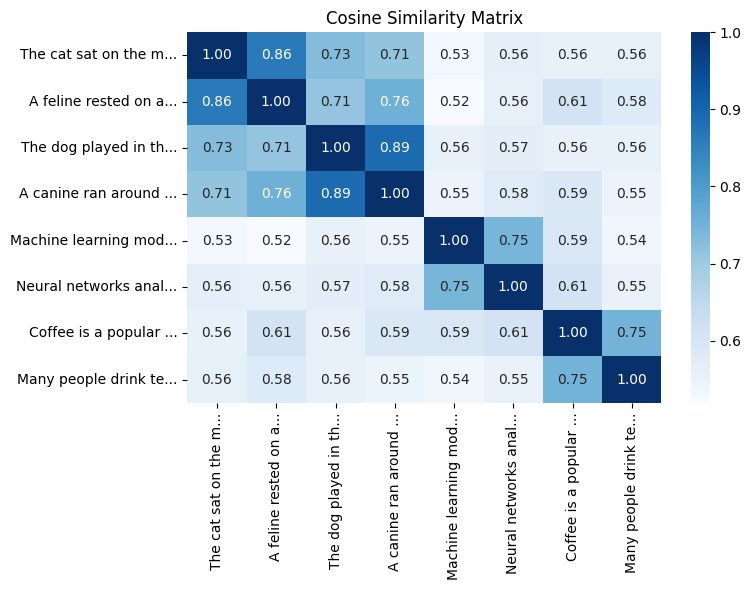

In [2]:
"Module for Visualising and understanding how embeddings work"
sample_texts = [
    "The cat sat on the mat",
    "A feline rested on a rug",
    "The dog played in the yard",
    "A canine ran around outside",
    "Machine learning models process data",
    "Neural networks analyze information",
    "Coffee is a popular morning beverage",
    "Many people drink tea in the afternoon"
]

def get_gemini_embedding(text):
    """Generate embeddings using Gemini model
    Args:
        text (str): Text to generate embedding for
    Returns:
        List : Embedding vector"""

    embedding_model = "models/embedding-001"
    try:
        embedding = genai.embed_content(
            model=embedding_model,
            content=text,
            task_type="retrieval_query"
        )
        return embedding["embedding"]
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return None

embeddings = []

"""Creating embeddings for each sentence we have defined above"""

for text in sample_texts:
    embedding = get_gemini_embedding(text)
    if embedding:
        embeddings.append(embedding)

embeddings_array = np.array(embeddings)

#Just to check the dimension of the embeddings
print("Embedding Shape : ", embeddings_array.shape)

# As the embeddings are 768 dimensional, we can use PCA to reduce the dimensionality to 2D for visualization
# PCA is nothing but a dimensionality reduction technique. Here it reduces the dimension 768 -> 2 ,so that we can visualise it in 2D.
# We use PCA, even if some information is lost, but not too much.

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Plotting the 2D embeddings using matplotlib

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.8)

for i, text in enumerate(sample_texts):
    plt.annotate(text, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title("2D Projection of Text Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Cosine Similarity and Euclidean Distance
# Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space.
# It is defined as the cosine of the angle between them. It is a value between -1 and 1, where 1 means the vectors are identical, 0 means they are orthogonal, and -1 means they are diametrically opposed.
# Euclidean distance is the straight-line distance between two points in Euclidean space. It is a measure of the "length" of the line segment connecting the two points.
# It is always non-negative, and it is 0 if the two points are identical.

def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors
    Args:
        v1 (list): First vector
        v2 (list): Second vector
    Returns:
        float: Cosine similarity value"""
    
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

def euclidean_distance(v1, v2):

    """Compute Euclidean distance between two vectors
    Args:
        v1 (list): First vector
        v2 (list): Second vector
    Returns:
        float: Euclidean distance value"""
    
    return np.linalg.norm(np.array(v1) - np.array(v2))

# Create similarity matrix for visualization
similarity_matrix = np.zeros((len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        similarity_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

# Plot similarity matirx using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=[t[:20] + "..." for t in sample_texts], 
            yticklabels=[t[:20] + "..." for t in sample_texts])
plt.title("Cosine Similarity Matrix")
plt.tight_layout()
plt.show()


In [3]:
"""Chunking in Rag Explanation"""
# In Retrieval-Augmented Generation (RAG), chunking is the process of dividing a large document or text corpus into smaller, manageable pieces or "chunks".
# This is essential for efficient retrieval and processing, especially when dealing with large datasets or documents that may not fit into memory all at once.
# Chunking allows the retrieval system to quickly search through smaller segments of text, improving the speed and accuracy of information retrieval.


def chunk_text(text, chunk_size=1000, overlap=200):
    """
    Split text into overlapping chunks of approximately equal size
    
    Args:
        text: Text to split into chunks
        chunk_size: Target size of each chunk in characters
        overlap: Number of characters to overlap between chunks
        
    Returns:
        List of text chunks
    """
    if len(text) <= chunk_size:
        return [text]
    
    chunks = []
    start = 0
    end = chunk_size
    
    while start < len(text):
        # Find the last period within the chunk to avoid splitting sentences
        if end < len(text):
            last_period = text.rfind(".", start, end)
            if last_period != -1 and last_period > start + chunk_size // 2:
                end = last_period + 1
        
        chunks.append(text[start:end])
        
        start = end - overlap
        end = start + chunk_size
        
        if end > len(text):
            end = len(text)
        if end == len(text):
            break
    
    return chunks

# Example document
sample_document = """
Retrieval-Augmented Generation (RAG) is a technique that enhances large language models by retrieving relevant information from external data sources to augment the generation process. RAG combines the strengths of pre-trained language models with the ability to access specific information that may not be part of the model's training data or that may change over time. This approach addresses several limitations of traditional language models, such as hallucinations, outdated information, and the inability to cite sources.

The RAG process begins with a query or prompt from a user. This query is converted into a vector representation, or embedding, using an embedding model. Simultaneously, a collection of documents or text passages from external sources are also converted into embeddings. These embeddings map text content into a high-dimensional space where semantic similarity can be measured mathematically.

Once both the query and document embeddings are created, the retrieval component searches for documents whose embeddings are most similar to the query embedding. This similarity search typically uses metrics like cosine similarity or Euclidean distance. The top-k most relevant documents are then retrieved and provided as additional context to the language model.

The generation component of RAG then uses both the original query and the retrieved documents to generate a response. This allows the model to ground its response in specific information while leveraging its pre-trained capabilities for natural language understanding and generation. The result is a response that is both contextually appropriate and factually accurate with respect to the retrieved information.

RAG systems can be implemented using various architectures. The embedding models can range from specialized bi-encoders like Sentence-BERT to more general models like those from OpenAI or Google's embedding APIs. For vector storage and retrieval, options include purpose-built vector databases like Pinecone, Weaviate, and ChromaDB, or extensions to traditional databases that support vector operations.

One of the key advantages of RAG is its flexibility. The retrieval corpus can be updated or modified without requiring retraining of the language model. This makes RAG particularly valuable for applications that need access to changing information, proprietary data, or domain-specific knowledge.

However, RAG also presents challenges. The quality of the generated output depends heavily on the relevance of the retrieved documents. If the retrieval system fails to find relevant information, the generation may default to the language model's general knowledge, potentially leading to inaccuracies. Additionally, managing and indexing large document collections efficiently requires careful consideration of factors such as chunking strategies, embedding models, and vector database configurations.

Despite these challenges, RAG has become an essential technique in the development of more reliable and grounded AI systems. It represents a significant step toward making large language models more useful and trustworthy for real-world applications.
"""

chunks = chunk_text(sample_document, chunk_size=400, overlap=100)

print(f"Original document length: {len(sample_document)} characters")
print(f"Number of chunks: {len(chunks)}")
for i, chunk in enumerate(chunks):
    print(f"\nChunk {i+1} ({len(chunk)} chars):")
    print(textwrap.fill(chunk, width=80))


Original document length: 3161 characters
Number of chunks: 12

Chunk 1 (371 chars):
 Retrieval-Augmented Generation (RAG) is a technique that enhances large
language models by retrieving relevant information from external data sources to
augment the generation process. RAG combines the strengths of pre-trained
language models with the ability to access specific information that may not be
part of the model's training data or that may change over time.

Chunk 2 (317 chars):
specific information that may not be part of the model's training data or that
may change over time. This approach addresses several limitations of traditional
language models, such as hallucinations, outdated information, and the inability
to cite sources.  The RAG process begins with a query or prompt from a user.

Chunk 3 (311 chars):
tion, and the inability to cite sources.  The RAG process begins with a query or
prompt from a user. This query is converted into a vector representation, or
embedding, using an emb

In [4]:
"""

# In RAG, we need to index the documents so that we can retrieve them efficiently.
# We can use a vector database like ChromaDB to store the embeddings and perform similarity searches.
# ChromaDB is a vector database that allows us to store and query embeddings efficiently.
# It is designed to work with large-scale embeddings and provides fast retrieval capabilities.
# Can use Vertex AI for this purpose as well.
"""
from chromadb import Documents, EmbeddingFunction, Embeddings

#This may be how the ChromaDB Abstraction of the method is defined.

"""
from chromadb import Documents, EmbeddingFunction, Embeddings

# This is how you can create your own embedding function which will work with chromadb.

class MyEmbeddingFunction(EmbeddingFunction):
    def __call__(self, input: Documents) -> Embeddings:
        # embed the documents somehow
        return embeddings

"""
class GeminiEmbeddingFunction(EmbeddingFunction):
    def __call__(self, texts):
        """Generate embeddings for a list of texts using Gemini
        Args:
            texts (List[str]): List of texts to generate embeddings for
        Returns:
            List[List[float]]: List of embedding vectors"""
        
        results = []
        for text in texts:
            try:
                embedding = genai.embed_content(
                    model="models/embedding-001",
                    content=text,
                    task_type="retrieval_document" 
                )
                results.append(embedding["embedding"])
            except Exception as e:
                print(f"Error generating embedding: {e}")
                # If there's an error, append a zero vector of the same size as the embedding
                results.append([0.0] * 768)  
            # Add a small delay to avoid rate limits in the gemini API
            time.sleep(0.1)
        return results

# Initialize ChromaDB
chroma_client = chromadb.Client()

gemini_ef  = GeminiEmbeddingFunction()

# Create or get a collection
collection = chroma_client.create_collection(
    name="rag_tutorial_4",
    embedding_function=gemini_ef
)

#Here we create DOC_IDs and metadata for the chunks
# Generate unique IDs for each chunk
doc_ids = [str(uuid.uuid4()) for _ in range(len(chunks))]
metadatas = [{"source": "RAG Tutorial", "chunk_id": i} for i in range(len(chunks))]

# Add chunks to collection
collection.add(
    documents=chunks,
    ids=doc_ids,
    metadatas=metadatas
)

print(f"Added {len(chunks)} documents to ChromaDB collection 'rag_tutorial'")

#Query and retrieve relevant documents
def retrieve_relevant_docs(query, k=3):
    """
    Retrieve relevant documents based on query

        Explanation:
            This function takes a query, generates its embedding using the Gemini model,
            and retrieves the top-k most relevant documents from the ChromaDB collection.
            It uses the cosine similarity metric to find the most similar documents.
        Args:
            query (str): The query text to search for
            k (int): The number of top documents to retrieve
        Returns:
            List[Dict[str, Any]]: List of retrieved documents with their metadata and distances

    """
    results = collection.query(
        query_texts=[query],
        n_results=k
    )
    
    retrieved_docs = []
    for i, doc in enumerate(results["documents"][0]):
        retrieved_docs.append({
            "document": doc,
            "id": results["ids"][0][i],
            "distance": results["distances"][0][i] if "distances" in results else None,
            "metadata": results["metadatas"][0][i]
        })
    
    return retrieved_docs

#This is how the query and retrieval process works.
# We can ask questions about the document and retrieve relevant chunks.
query = "What are the challenges of RAG systems?"
retrieved_docs = retrieve_relevant_docs(query, k=2)

print(f"Query: {query}")
print("\nRetrieved Documents:")
for i, doc in enumerate(retrieved_docs):
    print(f"\n--- Document {i+1} ---")
    print(f"Distance: {doc['distance']}")
    print(f"Metadata: {doc['metadata']}")
    print(textwrap.fill(doc['document'], width=80))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36404\405225518.py:52: DeprecationWarning: The class GeminiEmbeddingFunction does not implement __init__. This will be required in a future version.
  gemini_ef  = GeminiEmbeddingFunction()


Added 12 documents to ChromaDB collection 'rag_tutorial'
Query: What are the challenges of RAG systems?

Retrieved Documents:

--- Document 1 ---
Distance: 0.396921843290329
Metadata: {'source': 'RAG Tutorial', 'chunk_id': 9}
onal databases that support vector operations.  One of the key advantages of RAG
is its flexibility. The retrieval corpus can be updated or modified without
requiring retraining of the language model. This makes RAG particularly valuable
for applications that need access to changing information, proprietary data, or
domain-specific knowledge.  However, RAG also presents challenges.

--- Document 2 ---
Distance: 0.4191330671310425
Metadata: {'source': 'RAG Tutorial', 'chunk_id': 6}
ion while leveraging its pre-trained capabilities for natural language
understanding and generation. The result is a response that is both contextually
appropriate and factually accurate with respect to the retrieved information.
RAG systems can be implemented using various architectures

In [5]:
"""
Implementing Full RAG Pipeline with Gemini

"""
def rag_with_gemini(query, num_chunks=3, model="gemini-2.5-flash"):
    """
    Complete RAG pipeline using Gemini:
    1. Retrieve relevant chunks from the vector database
    2. Format prompt with retrieved chunks
    3. Generate response with Gemini
    
    Args:
        query: User question
        num_chunks: Number of chunks to retrieve
        model: Gemini model to use
        
    Returns:
        Generated response and retrieved document metadata
    """
    retrieved_docs = retrieve_relevant_docs(query, k=num_chunks)
    
    context = "\n\n".join([doc["document"] for doc in retrieved_docs])
    
    #Prompt to pass to the gemini model
    prompt = f"""
You are a helpful assistant answering questions based on the provided context.
Answer the following query using ONLY the information from the provided context.
If you cannot answer based solely on the context, say so clearly.

CONTEXT:
{context}

QUERY: {query}

ANSWER:
"""
    
    generation_config = {
        "temperature": 0.2,
        "max_output_tokens": 1024,
    }
    
    model = genai.GenerativeModel(model_name=model)
    response = model.generate_content(prompt, generation_config=generation_config)
    
    sources = []
    for doc in retrieved_docs:
        sources.append({
            "chunk_id": doc["metadata"]["chunk_id"],
            "text_snippet": doc["document"][:100] + "..."
        })
    
    return {
        "response": response.text,
        "sources": sources
    }


test_queries = [
    "What is Retrieval-Augmented Generation?",
    "How does the embedding process work in RAG?",
    "What are the challenges of implementing a RAG system?",
    "What databases can be used for RAG vector storage?"
]

for query in test_queries:
    print(f"\n{'='*80}\nQUERY: {query}\n{'='*80}")
    time.sleep(60)
    result = rag_with_gemini(query)
    
    print("\nRESPONSE:")
    print(textwrap.fill(result["response"], width=80))
    
    print("\nSOURCES:")
    for i, source in enumerate(result["sources"]):
        print(f"  Source {i+1} (Chunk {source['chunk_id']}):")
        print(f"  {source['text_snippet']}")
    print("\n")




QUERY: What is Retrieval-Augmented Generation?

RESPONSE:
Retrieval-Augmented Generation (RAG) is a technique that enhances large language
models by retrieving relevant information from external data sources to augment
the generation process.

SOURCES:
  Source 1 (Chunk 0):
  
Retrieval-Augmented Generation (RAG) is a technique that enhances large language models by retrievi...
  Source 2 (Chunk 10):
  information, proprietary data, or domain-specific knowledge.

However, RAG also presents challenges....
  Source 3 (Chunk 11):
  neration may default to the language model's general knowledge, potentially leading to inaccuracies....



QUERY: How does the embedding process work in RAG?

RESPONSE:
In RAG, the embedding process works as follows:  1.  A user's query or prompt is
converted into a vector representation, or embedding, using an embedding model.
2.  Simultaneously, a collection of documents or text passages from external
sources are also converted into embeddings. 3.  The embed